# Ram Shirazi - simple classfiers

First, the datasets are located in https://drive.google.com/drive/folders/15I5p8Y-gimjxlkpfxxfxtx2MLTBOOWO8?usp=sharing

In [ ]:
import matplotlib.pyplot as plt
import pickle

# my additions 
import cv2
import random
import numpy as np
import sklearn
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from skimage.feature import hog
from skimage import color
import time

Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read Train and Test datasets - Check out the images


In [ ]:
# Read Database 
def read_db(path):
    with open(path, 'rb') as handle:
      images  = pickle.load(handle)
      classes = pickle.load(handle)
    return images, classes

# Forest and glacier binary classifier



*  After a brief look at the images, one can concur thats this classifiction problem need to be resolevd via color space. trees are mostly green and glacier mostly white, also there is no common gemotrical shape to a Forests nor glaciers.  
*   In order to get a sense of which color space to use , i will plot histograms with thier respected images and label, in hope thats there is noticeable diffrence between the histograms of a glacier and Forests.

 



In [ ]:
# Read Train set
images_train, classes_train = read_db('/content/drive/MyDrive/Simple_classifier/train/forest_glacier_train.pkl')

# Read Test Set
images_test, classes_test = read_db('/content/drive/MyDrive/Simple_classifier/test/forest_glacier_test.pkl')

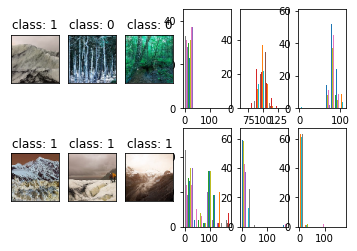

In [ ]:
for ii in range(12):
    col = ii % 6
    if col < 3:
      
        plt.subplot(2, 6, ii + 1)
        rand_im = np.random.randint(0, len(images_test))
        im = images_test[rand_im]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.title("class: " + str(classes_test[rand_im]))

        plt.subplot(2, 6, ii + 1 + 3)
        # histogram plot
        # change the image color space
        im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        # im = color.rgb2gray(im)
        plt.hist(im[:,:,0]) # choose the channel for the histogram 

plt.show()


First visualization of HSV color space. 

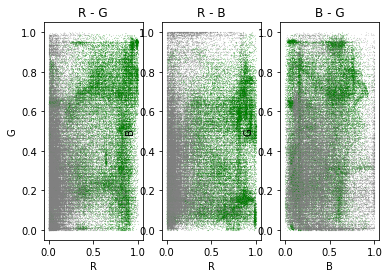

In [ ]:
scattRGB(images_test,classes_test)

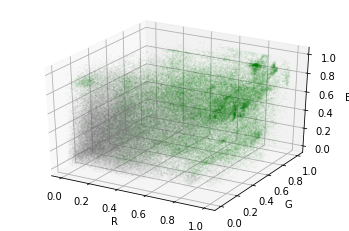

In [ ]:
scatt3dRGB(images_test,classes_test)

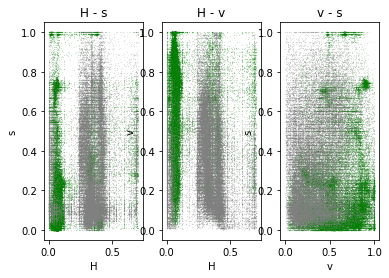

In [ ]:
scattHSV(images_test,classes_test)

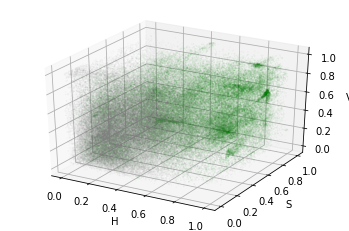

In [ ]:
scatt3dHSV(images_test,classes_test)



*   After ploting a few scatter plots for diffrent color space (RGB, HSV), i concluded that the features will be based on HSV color space , we can see  compressed and almost clear (only green or only red dots)  regions in the scatter plots , which indicate that our classifiar will have less uncertainty using features from the HSV color space. also from previos expirence i know that HSV color space is preferable for detection and tracking based on color.
at first, i tried using 3d scatter plot but rotation of the figure in google colab is imposable. we can see in the 2d scatter plots the diffrence between the color spaces very well. 
 


*   I wrote the ***images2features1(images)*** function which recive a list of RGB images and outputs a feature vector where the columbs represent the feature diminssions and the rows represnt the images. 



In [ ]:
def images2features1(images):
    print("creating a feature vector X using HSV channel and " + str(len(images)) + " images")
    hsv = np.asarray([(cv2.cvtColor(im, cv2.COLOR_RGB2HSV) / 255) for im in images])
    flag = True
    for channel in [hsv[:, :, :, 0], hsv[:, :, :, 1], hsv[:, :, :, 2]]:
        channel = np.reshape(channel, (len(channel[:, 1, 1]), len(channel[1, :, 1]) * len(channel[1, 1, :])))
        if flag:
            X = channel
            flag = False
        else:
            X = np.append(X, channel, axis=1)
    print("feature size = " +str(len(X[1,:])))
    return X

at first, I will try a naive approach, meaning that: 

1.   I did not try to reduce the dimensionality of the features space ,even though i have less samples then dimeinsions 
2.   I did not try to normalize our feature space. 
3.   I will use the default hyper-parameters for the classifier.  

i choose a SVM classifier, which preform very well on classifiction problems where we have features with high dimensionality comperd to the number of samples.     




In [ ]:
X_train = images2features1(images_train)
X_test = images2features1(images_test)

clf = svm.SVC()
t = time.time()
clf.fit(X_train, classes_train)
elapsed_t0 = time.time() - t
print("training time : "+ str(elapsed_t0) + "[sec]" )

t = time.time()
pred = clf.predict(X_test)
elapsed_p0 = time.time() - t
print("prediction time : "+ str(elapsed_p0) + "[sec]" )

conf_mat = sklearn.metrics.confusion_matrix(np.asarray(classes_test), pred)
accuracy = np.trace(conf_mat) / conf_mat.sum()
print("confusion matrix:")
print(conf_mat)
print('classifier accuracy = ' +str(accuracy))

creating a feature vector X using HSV channel and 4675images
feature size =12288
creating a feature vector X using HSV channel and 1027images
feature size =12288
training time : 92.56348872184753[sec]
training time : 19.335044384002686[sec]
confusion matrix:
[[457  17]
 [ 21 532]]
classifier accuracy = 0.9629990262901655


My classifier achieved sufficient results.

 now I will try to optimize the results by using :

1.   Normalization :  subtaract the mean of each columb in X and divide each coloumb with his standart diviation.   
2.   PCA : i will reduce the number of compmnents in the faeture space to half of the images number.
(to reduce the predict and training competition time) 


In [ ]:
# Normalization 
t = time.time()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
elapsed_n = time.time() - t
print("Normalization time : "+ str(elapsed_n) + "[sec]" )

# PCA
t = time.time()
n = int(len(X_train[:, 1])/2)
pca = PCA(n_components=n)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
elapsed_pca = time.time() - t
print("PCA time : "+ str(elapsed_pca) + "[sec]" )

In [ ]:
clf = svm.SVC()

t = time.time()
clf.fit(X_train, classes_train)
elapsed_t1 = time.time() - t
print("training time : "+ str(elapsed_t1) + "[sec]" )

t = time.time()
pred = clf.predict(X_test)
elapsed_p1 = time.time() - t
print("prediction time : "+ str(elapsed_p1) + "[sec]" )

conf_mat = sklearn.metrics.confusion_matrix(np.asarray(classes_test), pred)
accuracy = np.trace(conf_mat) / conf_mat.sum()
print("confusion matrix:")
print(conf_mat)
print('classifier accuracy = ' +str(accuracy))

training time : 17.304550170898438[sec]
prediction time : 3.4812214374542236[sec]
confusion matrix:
[[461  13]
 [ 23 530]]
classifier accuracy = 0.9649464459591042


The usage of PCA and normalization dramaticly decresed the computition time for training and predicting and even achived slightly better  classification  results  

# Mountain and buildings binary classifier

I will do the same steps as before (skipping on the histogram part). 

In [ ]:
# Read Train set
images_train, classes_train = read_db('/content/drive/MyDrive/WLD_AI/train/mountain_buildings_train.pkl')

# Read Test Set
images_test, classes_test = read_db('/content/drive/MyDrive/WLD_AI/test/mountain_buildings_test.pkl')

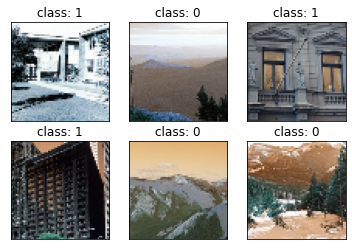

In [ ]:
for ii in range(6):
  plt.subplot(2, 3, ii + 1)
  rand_im = np.random.randint(0, len(images_test))
  im = images_test[rand_im]
  plt.imshow(im)
  plt.xticks([])
  plt.yticks([])
  plt.title("class: " + str(classes_test[rand_im]))
plt.show()

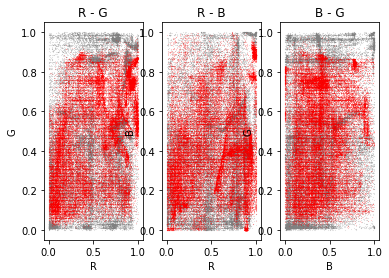

In [ ]:
scattRGB(images_test,classes_test,colors=['gray','red'])

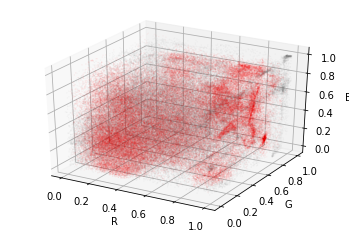

In [ ]:
scatt3dRGB(images_test,classes_test, colors=['gray','red'])

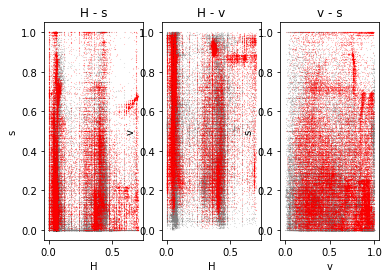

In [ ]:
scattHSV(images_test,classes_test, colors=['gray','red'])

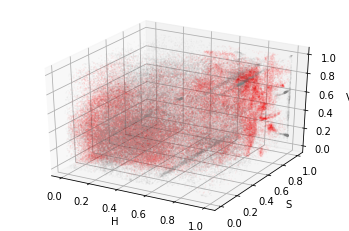

In [ ]:
scatt3dHSV(images_test,classes_test, colors=['gray','red'])

In contrast to the last classifiction problam, there is almost no clear regions in the HSV color space (RGB is worse), indicating that our classifier will deal with alot of uncertntiy. which makes sense because the colors between mountains and building arent differ like forest and glacier. from that we can guess that the classifier won't reach the same results as before. 



In [ ]:
X_train = images2features1(images_train)
X_test = images2features1(images_test)

clf = svm.SVC()
t = time.time()
clf.fit(X_train, classes_train)
elapsed_t0 = time.time() - t
print("training time : "+ str(elapsed_t0) + "[sec]" )

t = time.time()
pred = clf.predict(X_test)
elapsed_p0 = time.time() - t
print("prediction time : "+ str(elapsed_p0) + "[sec]" )

conf_mat = sklearn.metrics.confusion_matrix(np.asarray(classes_test), pred)
accuracy = np.trace(conf_mat) / conf_mat.sum()
print("confusion matrix:")
print(conf_mat)
print('classifier accuracy = ' +str(accuracy))

creating a feature vector X using HSV channel and 4703images
feature size =12288
creating a feature vector X using HSV channel and 962images
feature size =12288
training time : 254.2626736164093[sec]
prediction time : 51.764078855514526[sec]
confusion matrix:
[[456  69]
 [ 82 355]]
classifier accuracy = 0.843035343035343


We can see that the SVM took a lot more training and prediction time in adiition to getting less satasfing accuracy.

To solve this problam, we can say thats our feature space is insufficent, and we need to add diffrent kind of feature.

although the colors diffrence between mountains and buildings is minor, their common geometric shapes are pretty diffrent. we will utilize it using by adding **HOG features** to our feature space. 

I wrote the ***images2features2(imges)*** function which add to our HSV color feature space HOG features. 



In [ ]:
def images2features2(images):
    hsv = np.asarray([(cv2.cvtColor(im, cv2.COLOR_RGB2HSV) / 255) for im in images])
    HOG = np.asarray([hog(im, transform_sqrt=True, multichannel=True) for im in images])
    #transform_sqrt : Power law compression, also known as Gamma correction, 
    # is used to reduce the effects of shadowing and illumination variations
    flag = True
    for channel in [hsv[:, :, :, 0], hsv[:, :, :, 1], hsv[:, :, :, 2]]:
        channel = np.reshape(channel, (len(channel[:, 1, 1]), len(channel[1, :, 1]) * len(channel[1, 1, :])))
        if flag:
            X = channel
            flag = False
        else:
            X = np.append(X, channel, axis=1)

    X = np.append(X, HOG, axis=1)
    return X

I used PCA and normalization before the SVM model training (skiping the naive part).  

In [ ]:
X_train = images2features2(images_train)
X_test = images2features2(images_test)

# Normalization 
t = time.time()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
elapsed_n = time.time() - t
print("Normalization time : "+ str(elapsed_n) + "[sec]" )

# PCA
t = time.time()
n = int(len(X_train[:, 1])/2)
pca = PCA(n_components=n)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
elapsed_pca = time.time() - t
print("PCA time : "+ str(elapsed_pca) + "[sec]" )

clf = svm.SVC()

t = time.time()
clf.fit(X_train, classes_train)
elapsed_t1 = time.time() - t
print("training time : "+ str(elapsed_t1) + "[sec]" )

t = time.time()
pred = clf.predict(X_test)
elapsed_p1 = time.time() - t
print("prediction time : "+ str(elapsed_p1) + "[sec]" )

conf_mat = sklearn.metrics.confusion_matrix(np.asarray(classes_test), pred)
accuracy = np.trace(conf_mat) / conf_mat.sum()
print("confusion matrix:")
print(conf_mat)
print('classifier accuracy = ' +str(accuracy))

Normalization time : 1.552262783050537[sec]
PCA time : 153.02941727638245[sec]
training time : 33.41945481300354[sec]
prediction time : 6.674029111862183[sec]
confusion matrix:
[[512  13]
 [ 31 406]]
classifier accuracy = 0.9542619542619543


# scatter-functions

In [ ]:
def scattHSV(images,labels,colors = ['green', 'gray']):
    hsv = np.asarray([(cv2.cvtColor(im, cv2.COLOR_RGB2HSV) / 255) for im in images])
    h = hsv[:, :, :, 0]
    s = hsv[:, :, :, 1]
    v = hsv[:, :, :, 2]


    h = np.reshape(h, (len(h[:, 1, 1]), 64 ** 2))
    s = np.reshape(s, (len(s[:, 1, 1]), 64 ** 2))
    v = np.reshape(v, (len(v[:, 1, 1]), 64 ** 2))

    idx0 = [i for i, e in enumerate(labels) if e != 0]
    idx1 = [i for i, e in enumerate(labels) if e == 0]
    h_0 = h[idx0, :]
    h_1 = h[idx1, :]
    s_0 = s[idx0, :]
    s_1 = s[idx1, :]
    v_0 = v[idx0, :]
    v_1 = v[idx1, :]

    h_0 = random.choices(h_0, k=10)
    h_1 = random.choices(h_1, k=10)
    s_0 = random.choices(s_0, k=10)
    s_1 = random.choices(s_1, k=10)
    v_0 = random.choices(v_0, k=10)
    v_1 = random.choices(v_1, k=10)

    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)


    s = 0.005
    ax1.set_title("H - s")
    ax1.scatter(h_0, s_0, color=colors[0], s=s)
    ax1.scatter(h_1, s_1, color=colors[1], s=s)
    ax1.set_xlabel("H")
    ax1.set_ylabel("s")

    ax2.set_title("H - v")
    ax2.scatter(h_0, v_0, color=colors[0], s=s)
    ax2.scatter(h_1, v_1, color=colors[1], s=s)
    ax2.set_xlabel("H")
    ax2.set_ylabel("v")

    ax3.set_title("v - s")
    ax3.scatter(v_0, s_0, color=colors[0], s=s)
    ax3.scatter(v_1, s_1, color=colors[1], s=s)
    ax3.set_xlabel("v")
    ax3.set_ylabel("s")

    plt.show()

def scattRGB(images, labels, colors = ['green','gray']):
    rgb = np.asarray([im / 255.0 for im in images])
    r = rgb[:, :, :, 0]
    g = rgb[:, :, :, 1]
    b = rgb[:, :, :, 2]

    r = np.reshape(r, (len(r[:, 1, 1]), 64 ** 2))
    g = np.reshape(g, (len(g[:, 1, 1]), 64 ** 2))
    b = np.reshape(b, (len(b[:, 1, 1]), 64 ** 2))

    idx0 = [i for i, e in enumerate(labels) if e != 0]
    idx1 = [i for i, e in enumerate(labels) if e == 0]
    r_0 = r[idx0, :]
    r_1 = r[idx1, :]
    g_0 = g[idx0, :]
    g_1 = g[idx1, :]
    b_0 = b[idx0, :]
    b_1 = b[idx1, :]

    r_0 = random.choices(r_0, k=10)
    r_1 = random.choices(r_1, k=10)
    g_0 = random.choices(g_0, k=10)
    g_1 = random.choices(g_1, k=10)
    b_0 = random.choices(b_0, k=10)
    b_1 = random.choices(b_1, k=10)

    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    s = 0.005
    ax1.set_title("R - G")
    ax1.scatter(r_0, g_0, color=colors[0], s=s)
    ax1.scatter(r_1, g_1, color=colors[1], s=s)
    ax1.set_xlabel("R")
    ax1.set_ylabel("G")

    ax2.set_title("R - B")
    ax2.scatter(r_0, b_0, color=colors[0], s=s)
    ax2.scatter(r_1, b_1, color=colors[1], s=s)
    ax2.set_xlabel("R")
    ax2.set_ylabel("B")

    ax3.set_title("B - G")
    ax3.scatter(b_0, g_0, color=colors[0], s=s)
    ax3.scatter(b_1, g_1, color=colors[1], s=s)
    ax3.set_xlabel("B")
    ax3.set_ylabel("G")

    plt.show()


def scatt3dRGB(images,labels, colors = ['green','gray']):
    RGB_train = np.asarray(images) / 255.0
    RGB_test = np.asarray(images) / 255.0
    r = RGB_test[:, :, :, 0]
    g = RGB_test[:, :, :, 1]
    b = RGB_test[:, :, :, 2]

    r = np.reshape(r, (len(r[:, 1, 1]), 64 ** 2))
    g = np.reshape(g, (len(g[:, 1, 1]), 64 ** 2))
    b = np.reshape(b, (len(b[:, 1, 1]), 64 ** 2))

    idx0 = [i for i, e in enumerate(labels) if e != 0]
    idx1 = [i for i, e in enumerate(labels) if e == 0]
    r_0 = r[idx0, :]
    r_1 = r[idx1, :]
    g_0 = g[idx0, :]
    g_1 = g[idx1, :]
    b_0 = b[idx0, :]
    b_1 = b[idx1, :]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    r_0 = random.choices(r_0, k=20)
    r_1 = random.choices(r_1, k=20)
    g_0 = random.choices(g_0, k=20)
    g_1 = random.choices(g_1, k=20)
    b_0 = random.choices(b_0, k=20)
    b_1 = random.choices(b_1, k=20)


    ax.scatter(r_0, g_0, b_0, color=colors[0], s=0.001)
    ax.scatter(r_1, g_1, b_1, color=colors[1], s=0.001)
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    plt.show()

def scatt3dHSV(images, labels, colors = ['green','gray']):
    HSV = np.asarray(images) / 255.0
    h = HSV[:, :, :, 0]
    s = HSV[:, :, :, 1]
    v = HSV[:, :, :, 2]

    h = np.reshape(h, (len(h[:, 1, 1]), 64 ** 2))
    s = np.reshape(s, (len(s[:, 1, 1]), 64 ** 2))
    v = np.reshape(v, (len(v[:, 1, 1]), 64 ** 2))

    idx0 = [i for i, e in enumerate(labels) if e != 0]
    idx1 = [i for i, e in enumerate(labels) if e == 0]
    h_0 = h[idx0, :]
    h_1 = h[idx1, :]
    s_0 = s[idx0, :]
    s_1 = s[idx1, :]
    v_0 = v[idx0, :]
    v_1 = v[idx1, :]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    h_0 = random.choices(h_0, k=20)
    h_1 = random.choices(h_1, k=20)
    s_0 = random.choices(s_0, k=20)
    s_1 = random.choices(s_1, k=20)
    v_0 = random.choices(v_0, k=20)
    v_1 = random.choices(v_1, k=20)

    ax.scatter(h_0, s_0, v_0, color=colors[0], s=0.001)
    ax.scatter(h_1, s_1, v_1, color=colors[1], s=0.001)
    ax.set_xlabel("H")
    ax.set_ylabel("S")
    ax.set_zlabel("V")
    plt.show()
   #TNC